In [2]:
# Makes the display take up more of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
# Export
import numpy as np
import torch as T

from nb_files.nb_ReplayBuffer import ReplayBuffer
from nb_files.nb_DQN import DQN

In [53]:
# Export
class DDQN(object):
    def __init__(self, gamma, epsilon, lr, n_actions, input_dims,
                 mem_size, batch_size, eps_min=0.01, eps_dec=5e-7,
                 replace=1000, algo=None, env_name=None, chkpt_dir='tmp/ddqn'):
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.replace_target_cnt = replace
        self.algo = algo
        self.env_name = env_name
        self.chkpt_dir = chkpt_dir
        self.action_space = [i for i in range(n_actions)]
        self.learn_step_counter = 0
        
        self.dropout = 0.001
        self.dropout_max = 0.2

        self.memory = ReplayBuffer(mem_size, input_dims, n_actions)

        self.q_eval = DQN(self.lr, self.n_actions,
                                    input_dims=self.input_dims,
                                    name=self.env_name+'_'+self.algo+'_q_eval',
                                    chkpt_dir=self.chkpt_dir, dropout =self.dropout)
        self.q_next = DQN(self.lr, self.n_actions,
                                    input_dims=self.input_dims,
                                    name=self.env_name+'_'+self.algo+'_q_next',
                                    chkpt_dir=self.chkpt_dir, dropout =self.dropout)

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def sample_memory(self):
        state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)

        states = T.tensor(state).to(self.q_eval.device)
        rewards = T.tensor(reward).to(self.q_eval.device)
        dones = T.tensor(done).to(self.q_eval.device)
        actions = T.tensor(action).to(self.q_eval.device)
        next_states = T.tensor(new_state).to(self.q_eval.device)

        return states, actions, rewards, next_states, dones

    def choose_action(self, state):
        if np.random.random() > self.epsilon:
            state = T.tensor([state],dtype=T.float).to(self.q_eval.device)
            # need to turn off batch norm and dropout for network evaluation (batch size = 1)
            self.q_eval.eval() 
            actions = self.q_eval.forward(state)
            # need to turn on batch norm and dropout for network training
            self.q_eval.train()
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def replace_target_network(self):
        if self.replace_target_cnt is not None and \
           self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        if self.epsilon > self.eps_min:
            self.epsilon = self.epsilon - self.eps_dec 
        else: self.eps_min
    
    def update_dropout(self, model):
        for name, child in model.named_children():
            if isinstance(child, T.nn.Dropout):
                child.p=self.dropout
    
    def increase_dropout(self):
        if self.epsilon <= self.eps_min and self.dropout<=self.dropout_max:            
            self.dropout *= 1.001
        else: self.dropout
            
    def save_models(self):
        self.q_eval.save_checkpoint()
        self.q_next.save_checkpoint()

    def load_models(self):
        self.q_eval.load_checkpoint()
        self.q_next.load_checkpoint()

    def learn(self):
        if self.memory.memory_counter < self.batch_size:
            return

        self.q_eval.optimizer.zero_grad()

        self.replace_target_network()

        states, actions, rewards, next_states, dones = self.sample_memory()

        indices = np.arange(self.batch_size)

        q_pred = self.q_eval.forward(states)[indices, actions]
        q_next = self.q_next.forward(next_states)
        q_eval = self.q_eval.forward(next_states)

        max_actions = T.argmax(q_eval, dim=1)
        q_next[dones] = 0.0

        q_target = rewards + self.gamma*q_next[indices, max_actions]
        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()

        self.q_eval.optimizer.step()
        self.learn_step_counter += 1

        self.decrement_epsilon()

    

## Testing

In [64]:
agent=DDQN(gamma=0.99, epsilon=1.0, lr=0.0001,
                     input_dims=(4, 224, 224),
                     n_actions=7, mem_size=1000, eps_min=0.1,
                     batch_size=32, replace=10000, eps_dec=1e-3,
                     chkpt_dir='models/', algo='DDQN',
                     env_name='Test')

In [69]:
agent.chkpt_dir

'models/'

In [65]:
# check is increasing dropout and epsilon  decrease

In [66]:
eps_lst, dropout_lst, i_lst = [] ,[], []
for i in range(2000):
    agent.decrement_epsilon()
    eps_lst.append(agent.epsilon)
    
    agent.increase_dropout()
    dropout_lst.append(agent.dropout)
    
    i_lst.append(i)

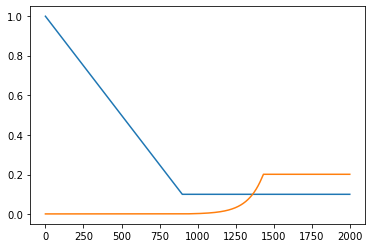

In [67]:
import matplotlib.pyplot as plt

plt.plot(i_lst, eps_lst)
plt.plot(i_lst, dropout_lst)
plt.show()

In [1]:
!python notebook2script.py Agent.ipynb

Converted Agent.ipynb to nb_files/nb_Agent.py


In [2]:
import datetime as dt
end=dt.datetime.now()
print(f'Finished: {end.strftime("%A %B %d, %Y")} at {end.strftime("%H:%M")}')

Finished: Wednesday March 09, 2022 at 18:15
